<a href="https://colab.research.google.com/github/ccamila/IA-aplicada-a-Saude/blob/main/TCC_ML_Sistema_circulatorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Realiza o mount do Google Drive para que possamos usá-lo como um diretório. Neste playbook, utilizaremos os arquivos csv que estão na pasta 'data' do Google Drive pessoal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Faz a leitura do csv diagnosis para um Dataframe e imprime os tipos das colunas

In [ ]:
import pandas as pd
import numpy as np

diagnosis_df = pd.read_csv("/content/drive/MyDrive/data/diagnosis.csv")
diagnosis_df.dtypes

subject_id      int64
stay_id         int64
seq_num         int64
icd_code       object
icd_version     int64
icd_title      object
dtype: object

In [ ]:
patients_df = pd.read_csv("/content/drive/MyDrive/data/patients.csv")
patients_df

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN
...,...,...,...,...,...,...
299707,19999828,F,46,2147,2017 - 2019,NaN
299708,19999829,F,28,2186,2008 - 2010,NaN
299709,19999840,M,58,2164,2008 - 2010,2164-09-17
299710,19999914,F,49,2158,2017 - 2019,NaN


Faz a leitura do csv vitalsign para um Dataframe e imprime os tipos das colunas

In [ ]:
vital_sign_df = pd.read_csv("/content/drive/MyDrive/data/vitalsign.csv")
vital_sign_df.dtypes

subject_id       int64
stay_id          int64
charttime       object
temperature    float64
heartrate      float64
resprate       float64
o2sat          float64
sbp            float64
dbp            float64
rhythm          object
pain            object
dtype: object

In [ ]:
patients_df['age'] = patients_df['anchor_age']
patients_df.drop(['anchor_year', 'anchor_year_group', 'dod', 'anchor_age'], axis=1, inplace=True)

Mo próximo bloco, transformaremos o valor de 'gender' para int. F se tornará 0 e M, 1.

In [ ]:
patients_df['gender'] = np.where(patients_df['gender'] == 'F', 0, 1)

In [ ]:
patients_df.drop(patients_df[patients_df['age'] > 81].index, inplace=True)

Removendo do dataframe a coluna 'icd_title' pois ela não será útil. O método que utilizaremos só aceita colunas numéricas

In [ ]:
diagnosis_df = diagnosis_df.drop("icd_title", axis=1)

Seguindo na ideia de preparar o dataset 'diagnosis' para aplicar o DL, criei uma coluna 'icd_code_num' que inicializo todas as linhas com o valor '0'. Assim, posso atribuir o valor '1' para as linhas que contiverem o diagnóstico que estamos buscando.

In [ ]:
diagnosis_df['icd_code_num'] = 0

Começaremos agora a busca pelas doenças do sistema circulatório. No CID 9, são as doenças que tem número de 390 a 459. No CID 10, são os códigos que começam com o caractere 'I'. Como icd_code é uma coluna de strings, usarei o método 'startswith' para realizar essa busca.

> Esse método aceita uma string ou então uma tupla de strings caso deseje realizar uma busca múltipla.

Além disso, atribuirei o valor '1' à coluna icd_code_num para sinalizar que está linha indica o diagnóstico desejado.






In [ ]:
disease_codes_tuple = ()
# 390 a 459 são as doenças do sistema circulatório. No range o último número não é incluído incluido
for i in range(390, 460):
  disease_codes_tuple = disease_codes_tuple + (str(i),)

Depois de terminar a coluna 'icd_code_num', removo as colunas 'icd_version' e 'icd_code' pois elas não tem tipo numério e não tem mais utilidade.

In [ ]:
diagnosis_df.loc[(diagnosis_df['icd_code'].str.startswith("I")) & (diagnosis_df['icd_version'] == 10), 'icd_code_num'] = 1
diagnosis_df.loc[(diagnosis_df['icd_code'].str.startswith("disease_codes_tuple")) & (diagnosis_df['icd_version'] == 9), 'icd_code_num'] = 1
diagnosis_df = diagnosis_df.drop(["icd_version", "icd_code"], axis=1)
diagnosis_df

,subject_id,stay_id,seq_num,icd_code_num
0,10000032,32952584,1,0
1,10000032,32952584,2,0
2,10000032,32952584,3,0
3,10000032,33258284,1,0
4,10000032,33258284,2,0
...,...,...,...,...
899045,19999828,30712109,1,0
899046,19999828,32917002,1,0
899047,19999828,32917002,2,0
899048,19999914,32002659,1,0


Nesse próximo bloco, realizamos um agrupamento com subject_id e stay_id, assim podemos saber com que doenças o paciente foi diagnosticado em uma determinada visita.

In [ ]:
# A função lambda verifica se existe o valor '1' na coluna icd_code_num em cada grupo
# Reset_index foi usada para transformar o GroupbyDataFrame em um DataFrame normal
diagnosis_df = diagnosis_df.groupby(['subject_id', 'stay_id'])[['icd_code_num']].apply(lambda x: int(1 in x['icd_code_num'].values)).reset_index(name="icd_code_num")


In [ ]:
diagnosis_df.loc[diagnosis_df['icd_code_num']==1]

,subject_id,stay_id,icd_code_num
17,10000285,36555703,1
23,10000635,31767754,1
36,10000980,31236252,1
37,10000980,31499674,1
42,10000980,36549081,1
...,...,...,...
423908,19997911,33281809,1
423926,19998350,32182941,1
423932,19998350,36646275,1
423934,19998350,39259698,1


In [ ]:
diagnosis_df

,subject_id,stay_id,icd_code_num
0,10000032,32952584,0
1,10000032,33258284,0
2,10000032,35968195,0
3,10000032,38112554,0
4,10000032,39399961,0
...,...,...,...
423984,19999784,37972930,0
423985,19999828,30712109,0
423986,19999828,32917002,0
423987,19999914,32002659,0


In [ ]:
vital_sign_df

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,32952584,2180-07-22 16:36:00,NaN,83.0,24.0,97.0,90.0,51.0,NaN,0
1,10000032,32952584,2180-07-22 16:43:00,NaN,85.0,22.0,98.0,76.0,39.0,NaN,0
2,10000032,32952584,2180-07-22 16:45:00,NaN,84.0,22.0,97.0,75.0,39.0,NaN,0
3,10000032,32952584,2180-07-22 17:56:00,NaN,84.0,20.0,99.0,86.0,51.0,NaN,NaN
4,10000032,32952584,2180-07-22 18:37:00,98.4,86.0,20.0,98.0,65.0,37.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1564605,19999828,32917002,2149-01-08 17:10:00,98.1,109.0,15.0,96.0,111.0,78.0,NaN,NaN
1564606,19999914,32002659,2158-12-24 11:43:00,99.5,81.0,10.0,100.0,93.0,55.0,NaN,0
1564607,19999987,34731548,2145-11-02 19:40:00,NaN,112.0,18.0,NaN,118.0,83.0,NaN,NaN
1564608,19999987,34731548,2145-11-02 20:11:00,NaN,111.0,18.0,NaN,123.0,82.0,NaN,unable


Para tratar o dataset 'vitalsign', devemos transformas as colunas de tipo object em numeric. Deste modo, os valores NaN irão receber o valor '-1'. Na coluna 'pain', os valores não numéricos foram transformados em '-1'

In [ ]:
vital_sign_df.fillna(value=-1, inplace=True)

In [ ]:
vital_sign_df.loc[~vital_sign_df['pain'].isin([str(i) for i in range(0, 10)]), 'pain'] = -1
vital_sign_df['pain'] = vital_sign_df['pain'].astype(int)
vital_sign_df

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,32952584,2180-07-22 16:36:00,-1.0,83.0,24.0,97.0,90.0,51.0,-1,0
1,10000032,32952584,2180-07-22 16:43:00,-1.0,85.0,22.0,98.0,76.0,39.0,-1,0
2,10000032,32952584,2180-07-22 16:45:00,-1.0,84.0,22.0,97.0,75.0,39.0,-1,0
3,10000032,32952584,2180-07-22 17:56:00,-1.0,84.0,20.0,99.0,86.0,51.0,-1,-1
4,10000032,32952584,2180-07-22 18:37:00,98.4,86.0,20.0,98.0,65.0,37.0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
1564605,19999828,32917002,2149-01-08 17:10:00,98.1,109.0,15.0,96.0,111.0,78.0,-1,-1
1564606,19999914,32002659,2158-12-24 11:43:00,99.5,81.0,10.0,100.0,93.0,55.0,-1,0
1564607,19999987,34731548,2145-11-02 19:40:00,-1.0,112.0,18.0,-1.0,118.0,83.0,-1,-1
1564608,19999987,34731548,2145-11-02 20:11:00,-1.0,111.0,18.0,-1.0,123.0,82.0,-1,-1


Para tratar a coluna 'rhythm', cada valor recebeu uma codificação numerica. Isso foi feito criada uma lista com os distintos valores e então atribuido um número e salvando no dicionário 'rhythm_dict'. Nele, as chaves são os valores de 'rhythm' e os valores são os números.

In [ ]:
import numpy as np

unique_rhythms = vital_sign_df['rhythm'].unique().tolist()

rhythm_dict = {}
for index, unique_rhythm in enumerate(unique_rhythms):
  rhythm_dict[unique_rhythm] = index


In [ ]:
vital_sign_df['rhythm'] = [rhythm_dict[item] for item in vital_sign_df['rhythm']]
vital_sign_df.dtypes

subject_id       int64
stay_id          int64
charttime       object
temperature    float64
heartrate      float64
resprate       float64
o2sat          float64
sbp            float64
dbp            float64
rhythm           int64
pain             int64
dtype: object

In [ ]:
vital_sign_df.groupby(['subject_id', 'stay_id']).first().reset_index()


,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,32952584,2180-07-22 16:36:00,-1.0,83.0,24.0,97.0,90.0,51.0,0,0
1,10000032,33258284,2180-05-06 23:04:00,97.7,79.0,16.0,98.0,107.0,60.0,0,0
2,10000032,35968195,2180-08-05 23:50:00,98.5,96.0,17.0,100.0,102.0,58.0,0,-1
3,10000032,38112554,2180-06-26 18:42:00,97.9,76.0,18.0,95.0,95.0,64.0,0,5
4,10000032,39399961,2180-07-23 07:19:00,-1.0,79.0,18.0,93.0,86.0,57.0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
408141,19999784,37972930,2119-07-09 17:38:00,98.0,91.0,16.0,99.0,148.0,90.0,0,5
408142,19999828,30712109,2147-07-17 17:19:00,98.1,83.0,18.0,100.0,107.0,75.0,0,8
408143,19999828,32917002,2149-01-08 09:12:00,96.6,112.0,18.0,100.0,110.0,82.0,0,4
408144,19999914,32002659,2158-12-24 11:43:00,99.5,81.0,10.0,100.0,93.0,55.0,0,0


In [ ]:
merged_df = diagnosis_df.merge(vital_sign_df.groupby(['subject_id', 'stay_id']).last().reset_index(), on=['subject_id', 'stay_id'], how='inner')

In [ ]:
merged_df = merged_df.merge(patients_df, on='subject_id', how='inner')

In [ ]:
merged_df = merged_df.drop("charttime", axis=1)
merged_df = merged_df.drop("subject_id", axis=1)
merged_df = merged_df.drop("stay_id", axis=1)

In [ ]:
merged_df

,icd_code_num,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain,gender,age
0,0,98.2,85.0,18.0,98.0,81.0,38.0,0,0,0,52
1,0,97.7,79.0,16.0,98.0,107.0,60.0,0,0,0,52
2,0,98.1,91.0,18.0,99.0,98.0,60.0,0,-1,0,52
3,0,97.9,86.0,17.0,93.0,96.0,57.0,0,-1,0,52
4,0,-1.0,96.0,18.0,97.0,86.0,45.0,0,-1,0,52
...,...,...,...,...,...,...,...,...,...,...,...
377426,0,97.4,76.0,16.0,99.0,142.0,80.0,0,3,1,57
377427,0,99.6,78.0,17.0,99.0,108.0,87.0,0,-1,0,46
377428,0,98.1,109.0,15.0,96.0,111.0,78.0,0,-1,0,46
377429,0,99.5,81.0,10.0,100.0,93.0,55.0,0,0,0,49


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(merged_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [ ]:
neg, pos = np.bincount(merged_df['icd_code_num'])
# target = merged_df.pop('icd_code_num')
# neg, pos = np.bincount(target)
# total = neg + pos
# print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
#     total, pos, 100 * pos / total))

In [ ]:
pos_df = train_df.loc[train_df['icd_code_num'] == 1]
neg_df = train_df.loc[train_df['icd_code_num'] == 0]

In [ ]:
BUFFER_SIZE = 100000
EPOCHS = 100
BATCH_SIZE = 2048
def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds
pos_labels = pos_df.pop('icd_code_num')
pos_dataset = make_ds(pos_df.values, pos_labels.values)
neg_labels = neg_df.pop('icd_code_num')
neg_dataset= make_ds(neg_df.values, neg_labels.values)
# dataset = tf.data.Dataset.from_tensor_slices((merged_df.values, target.values))

In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_dataset, neg_dataset], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

336.0

In [ ]:
# dataset_size = len(merged_df)
# dataset = dataset.shuffle(dataset_size, seed=10)

# train_dataset = dataset.take(int(dataset_size * 0.8)).batch(1024)
# test_dataset = dataset.skip(int(dataset_size * 0.8)).take(int(dataset_size * 0.1)).batch(1024)
# validation_dataset = dataset.skip(int(dataset_size * 0.8)).skip(int(dataset_size * 0.1)).take(int(dataset_size * 0.1)).batch(1024)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(axis=1),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])

# def get_compiled_model():
#   model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(10, return_sequences=False),
#     tf.keras.layers.core.Dropout(0.2),
#     tf.keras.layers.Dense(1),
#     tf.keras.layers.core.Activation("sigmoid"),
#   ])


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='binary_crossentropy',
                metrics=METRICS)
  return model

In [ ]:
from keras import callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
validation_labels = val_df.pop('icd_code_num')
validation_dataset = tf.data.Dataset.from_tensor_slices((val_df.values, validation_labels.values)).batch(BATCH_SIZE)

test_labels = test_df.pop('icd_code_num')
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.values, test_labels.values)).batch(BATCH_SIZE)

In [ ]:
model = get_compiled_model()
training_history = model.fit(resampled_ds, epochs=EPOCHS, steps_per_epoch=resampled_steps_per_epoch, callbacks=[early_stopping], validation_data=validation_dataset)

Epoch 1/100
336/336 [==============================] - 35s 98ms/step - loss: 0.6910 - tp: 234284.0000 - fp: 146227.0000 - tn: 197923.0000 - fn: 109694.0000 - accuracy: 0.6281 - precision: 0.6157 - recall: 0.6811 - auc: 0.6685 - prc: 0.6270 - val_loss: 0.6620 - val_tp: 4535.0000 - val_fp: 27605.0000 - val_tn: 27395.0000 - val_fn: 854.0000 - val_accuracy: 0.5287 - val_precision: 0.1411 - val_recall: 0.8415 - val_auc: 0.7274 - val_prc: 0.1777
Epoch 2/100
336/336 [==============================] - 35s 105ms/step - loss: 0.6241 - tp: 267010.0000 - fp: 157242.0000 - tn: 187217.0000 - fn: 76659.0000 - accuracy: 0.6601 - precision: 0.6294 - recall: 0.7769 - auc: 0.7079 - prc: 0.6594 - val_loss: 0.5922 - val_tp: 4251.0000 - val_fp: 24510.0000 - val_tn: 30490.0000 - val_fn: 1138.0000 - val_accuracy: 0.5753 - val_precision: 0.1478 - val_recall: 0.7888 - val_auc: 0.7303 - val_prc: 0.1816
Epoch 3/100
336/336 [==============================] - 32s 95ms/step - loss: 0.6094 - tp: 276394.0000 - fp: 161

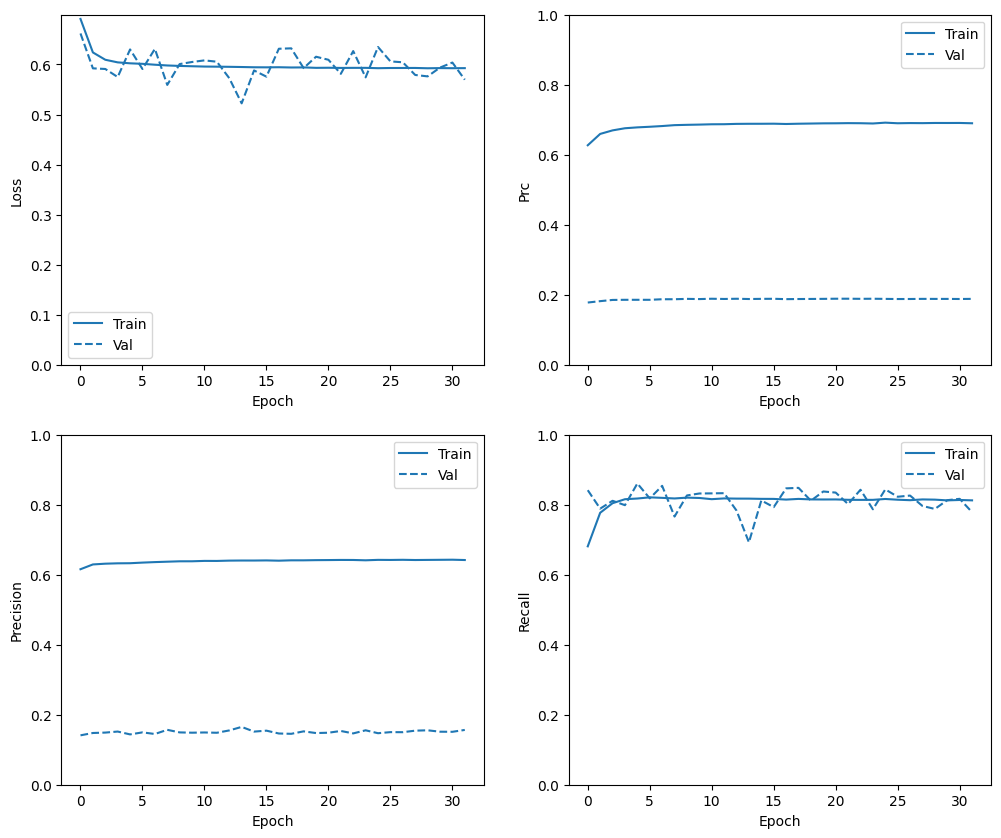

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

plot_metrics(training_history)

In [ ]:
train_predictions_resampled = model.predict(train_dataset, batch_size=BATCH_SIZE)
test_predictions_resampled = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
resampled_results = model.evaluate(test_dataset,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)